In [1]:
import praw #reddit scraper
import pandas as pd #dataframe to organize data
import getpass #hiding password and login credentials
from datetime import datetime #for converting datetime from reddit time object
import pprint #use to check functionality of praw objects
import string #use to clean punctuations

In [2]:
from wordcloud import WordCloud #use to create wordcloud
import matplotlib.pyplot as plt #library for visualizations
plt.style.use('fivethirtyeight')

In [3]:
#importing and using nltk library for text analysis
from nltk.tokenize import sent_tokenize #for sentence tokenizing
from nltk.tokenize import word_tokenize #splitting up the words into individual object
from nltk.corpus import stopwords #Examples of stop words in English are “a”, “the”, “is”, “are” and etc
from nltk.stem import PorterStemmer #root word
from nltk.stem import WordNetLemmatizer #sort words by grouping inflected or variant forms of the same word
from nltk.stem import wordnet #needed for lemmatizing words
from nltk.probability import FreqDist #count distribution of words
from nltk.util import bigrams, trigrams, ngrams #analyzing consecutive uses of words
import seaborn as sns #used for barchart
from nltk import pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer

In [4]:
#config file with my reddit api credentials
import reddit_config

In [5]:
#gaining access into reddit
reddit = praw.Reddit(client_id=reddit_config.client_id,
                     client_secret=reddit_config.client_secret,
                     user_agent=reddit_config.user_agent)

In [6]:
#defining subreddit
antiwork_sub = reddit.subreddit('antiwork')

In [7]:
#Gathering thread information and top posts. Also defining how many top posts to grab
posts = []
for post in antiwork_sub.top("all",limit=200):
    posts.append([post.title,datetime.utcfromtimestamp(post.created).strftime('%Y-%m-%d %H:%M:%S'),post.permalink])

In [8]:
#organizing thread information into panda dataframe
posts = pd.DataFrame(posts,columns=['title','created','link'])

In [9]:
#gathering top level 1 comments from reddit posts, capping at 25
comments_data = []

for each_post in posts.link: #looping through each url link to get inside each post
    submission = reddit.submission(url="https://www.reddit.com" + each_post)
    submission.comment_sort = 'top' #sorting comments by top
    #submission.comment_limit = 25
    submission.comments.replace_more(limit=0) #removing replies from comments
    comment_list = submission.comments.list() #converting comment objects into list
    
    n=0
    
    for comment in comment_list:
        if n < 50:
            comments_data.append([comment.body,comment.score])
        n += 1

In [10]:
#organzing comment data using panda
pd_comments = pd.DataFrame(comments_data, columns=['Comments','Score'])

In [11]:
#testing if comments were gathered
pd_comments.Comments

0       OP has posted an update. I've linked it below:...
1       I wonder if boss man was sitting on a stool wh...
2       It still perplexes me why they care if you're ...
3       lol the backpedaling is precious: \n\n‘YOUR IN...
4       Hell yea!! They sound horrible, treated you li...
                              ...                        
9995    Everyone here should consider joining their lo...
9996    Sorry, but a union is important. Tha union is ...
9997    I’d like to see as much free time as possible,...
9998    One thing we really need right now is more mut...
9999    From an economics perspective anti work is bet...
Name: Comments, Length: 10000, dtype: object

In [12]:
#creating a list of all the words
words = []

for a in pd_comments.Comments:
    words.append(a)

strings = ' '.join(words).lower() #converting list of words into string so i can tokenize the words

In [13]:
#inital cleaning, taking out the punctuations
cleaned_string = strings.translate(str.maketrans('', '', string.punctuation))

In [14]:
#tokenizing words so each word becomes an individual object
tokenized_words = word_tokenize(cleaned_string)

In [15]:
#filtering out stop words
stop_words = set(stopwords.words("english")) #defining a list of stop words

#creating a list of filtered out words
filtered_words = []

for words in tokenized_words:
    if words not in stop_words:
        filtered_words.append(words)

In [16]:
#more cleaning on characters not caught by string.punctuation, or any words I'd like to exclude
characters_to_remove = ["‘","’","”","“","ive","like","shit","bullshit"]
cleaned_words = [word for word in filtered_words if word not in set(characters_to_remove)]
#Lemmatization:converts the word into its root word
#It makes use of the vocabulary and does a morphological analysis to obtain the root word.
wrn_lemma = WordNetLemmatizer()
lemma_list = []
#using pos_tag to find better lemmatize rather than the default setting
for word, tag in pos_tag(cleaned_words):
    new_tag = tag[0].lower()
    #whether the word is adj,adv,nonu,verb
    new_tag = new_tag if new_tag in ['a','r','n','v',] else None
    if not new_tag:
        lemma_list.append(word)
    else:
        lemma_list.append(wrn_lemma.lemmatize(word,new_tag))

In [17]:
#Stemming: process of linguistic normalization
#which reduces words to their word root word or chops off the derivational affixes
ps = PorterStemmer()

stemmed_words = []

for words in lemma_list:
    stemmed_words.append(ps.stem(words))

In [18]:
#double cleaning on stop words once stemmed and lemmatized and cleaned punctuation
final_clean = [word for word in stemmed_words if word not in stop_words]

<function matplotlib.pyplot.show(*args, **kw)>

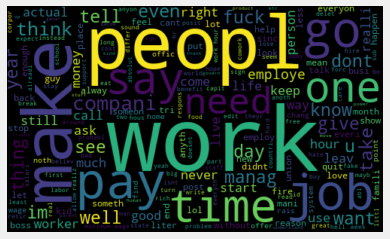

In [19]:
#word cloud and parameter
allwords = ' '.join(final_clean)
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(allwords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show

In [20]:
#creating a column of tokenzied words using panda
pd_clean = pd.DataFrame(final_clean, columns=['Token'])

In [21]:
#defing sentiment anaylsis to determine whether the word is positive, negative, neutral
sia = SentimentIntensityAnalyzer()

#only taking the compound score
def sent_score(text):
    return sia.polarity_scores(text)['compound']

In [22]:
#using applymap to create a new column labeling the polarity score
pd_clean['Polarity'] = pd_clean['Token'].apply(sent_score)

In [23]:
#defing whether the word is positve:1, negative:0, or neutral:2
def sentiment(polarity):
    if polarity > 0:
        return 1
    elif polarity == 0:
        return 2
    else:
        return 0

In [24]:
#applying the labeling into each word while creating new column
pd_clean['Sentiment'] = pd_clean['Polarity'].apply(sentiment)

In [25]:
#filtering to only negative words to do an negative sentiment analysis
#can which to filter to 1 for positive, or 2 for netural and rerun the code
sent_words = pd_clean['Token'][pd_clean['Sentiment']==0]

In [26]:
#creating a list of all the negative words
all_sent_words = []

for word in sent_words:
    all_sent_words.append(word)
    

In [27]:
#calcualting all the frequence distribution of all the negative words
fdist = FreqDist(all_sent_words)
#then organizing it into a panda data frame
sent_df = pd.DataFrame({'Words':list(fdist.keys()),
                     'Count':list(fdist.values())})
#pw_df

<function matplotlib.pyplot.show(*args, **kw)>

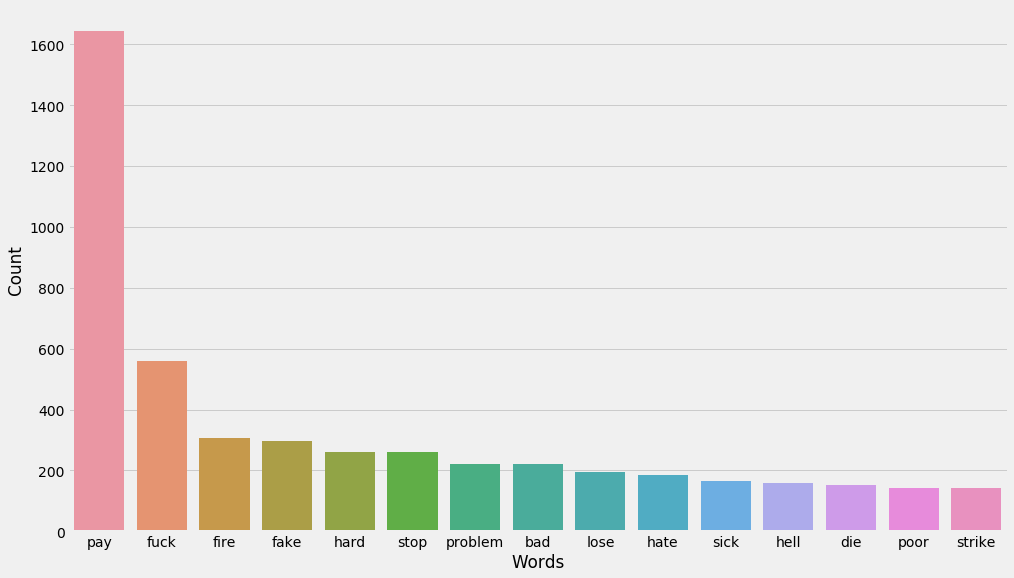

In [28]:
#setting the parameter for bar chart
sent_bar = sent_df.nlargest(columns='Count', n=15)

#setting parameter
plt.figure(figsize=(15,9))
sns.barplot(data=sent_bar,x='Words',y='Count')
plt.show

In [29]:
#setting up a list for bigram analysis
#consecutive words
w_bigrams = list(bigrams(final_clean))
bi_list = []
for a in w_bigrams:
    bi_list.append(list(a)) #making it into a list of items so i can unpack it later

In [30]:
#organzing the bigram list into a data frame
bg_df = pd.DataFrame({'Bis':bi_list})

In [31]:
#unpacking the bigrams in data frame
def unnest(nest):
    return ' '.join(nest)

In [32]:
#creating the unnested columns
bg_df['Bigrams'] = bg_df['Bis'].apply(unnest)

In [33]:
#labeling the bigrams with sentiment score
bg_df['Polarity'] = bg_df['Bigrams'].apply(sent_score)

In [34]:
#labeling the bigrams with 1 for positive, 0 for negative, 2 for neutral
bg_df['Sentiment'] = bg_df['Polarity'].apply(sentiment)

In [35]:
#filtering into negative bigrams only for analysis.
#can change the filter to 1 for positive, 2 for neutral
bi_sent_words = bg_df['Bigrams'][bg_df['Sentiment']==0]

In [36]:
#creating a list of all negative bigram words
all_bi_words = []
for word in bi_sent_words:
    all_bi_words.append(word)

In [37]:
#calcualting all the frequence distribution of all the negative bigrams
bi_fdist = FreqDist(all_bi_words)
biw_df = pd.DataFrame({'Words':list(bi_fdist.keys()),
                     'Count':list(bi_fdist.values())})
#biw_df

<function matplotlib.pyplot.show(*args, **kw)>

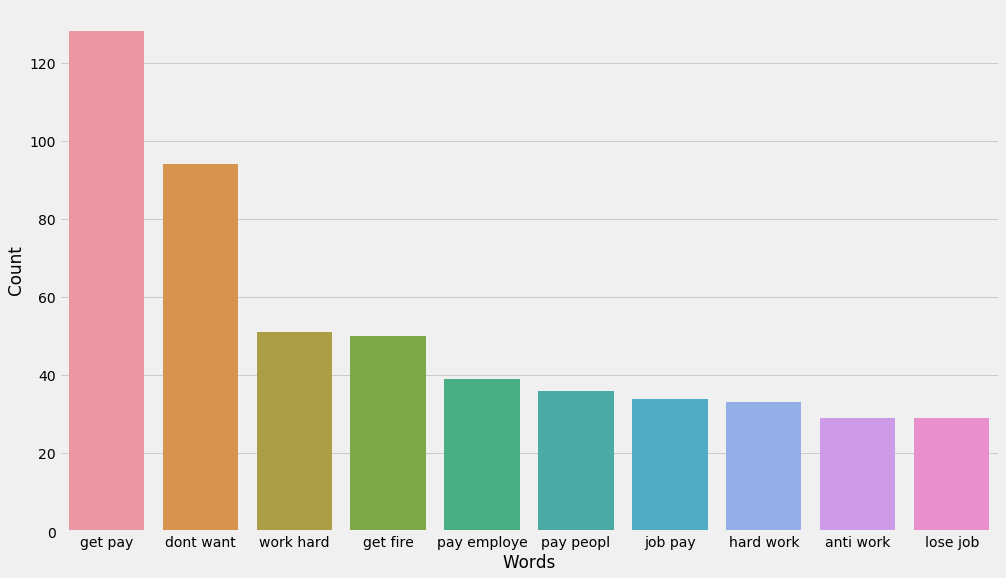

In [38]:
#setting the parameter to showing only top 10
biw_bar = biw_df.nlargest(columns='Count', n=10)

#bar chart parameters
plt.figure(figsize=(15,9))
sns.barplot(data=biw_bar,x='Words',y='Count')
plt.show